# Convolutional Neural Network (CNN)

CNNs is the neural network layer used when working with image data. In this notebook, we will see how to implement CNN based neural networks.  We will be using the [pytorch](http://pytorch.org/) deep learning library. Please have a look at the pytorch website. It has more additional material, specifically:
- The pytorch website has a many [tutorials](http://pytorch.org/tutorials/) that you can follow additionally.
- There is also an [api reference](http://pytorch.org/docs/0.3.1/), for refereing the definitions of functions and classes.

As we saw in the lecture, deep learning programming involves the following steps:

1. Specifying the dataset and how it should be loaded.
2. Specifying a Neural Network Model 
3. Specify the Loss function and Gradient Update Algorithm
4. Training Loop 
5. Compute the Accuracy on Testing dataset

First we will start with some import statements.

In [3]:
# Importing torch library, which is a popular one for deep learning
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.functional as F

# OS is a standard python library, which we use for accessing the file system.
import os

# Matplotllib is used for ploting graphs
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

## Step 1: Data Loading
We will be using the MNIST handwritten images dataset. The dataset is split in to 2 parts:
- train which consists of 60000 images 
- test of 10000 images. 

These images are represeted as a 28x28 matrix.

Shape of the training data (no of images, height, width) :  torch.Size([60000, 28, 28])
Shape of the testing data (no of images, height, width) :  torch.Size([10000, 28, 28])


###### An Example Image, Label pair ############


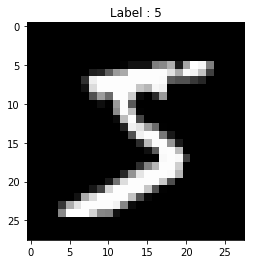

In [4]:
# Some code, to check if dataset is already downloaded.
DOWNLOAD_MNIST = False
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True

# Loading the training data
mnist_train = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# Similarly loading the testing data
mnist_test = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,                                     
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,
)


# ploting one example
print("Shape of the training data (no of images, height, width) : ", mnist_train.train_data.size()) # (60000, 28, 28)
print("Shape of the testing data (no of images, height, width) : ", mnist_test.test_data.size())  # (10000, 28, 28)
print("\n")
print("###### An Example Image, Label pair ############")
plt.imshow(mnist_train.train_data[0].numpy(), cmap='gray')
plt.title('Label : %i' % mnist_train.train_labels[0])
plt.show()



### Minibatch
Machine learning dataset can be really large. Hence we cannot often load the entire data in to the memory. Hence neural network training is done by loading small batches (commonly called minibatch) of data, and using it to update the learnable parameters (weights and biases) of the model.

Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) 9


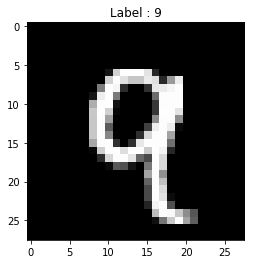

torch.Size([1, 28, 28]) 0


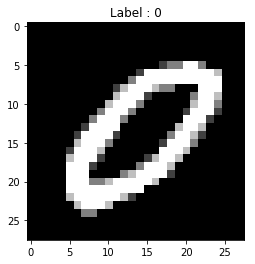

Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) 4


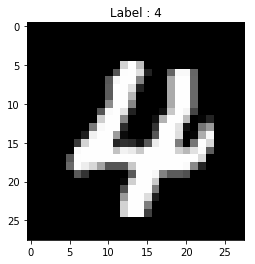

torch.Size([1, 28, 28]) 7


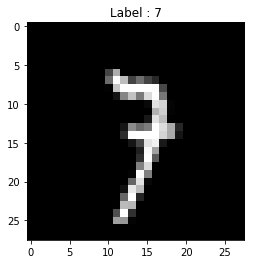

In [5]:
batch_size = 1000 # The mini batch size used for doing the training


# Data Loader for easy mini-batch return in training, the image batch shape will be (batch_size, 1, 28, 28)
train_loader = Data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = Data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=True)

count = 0
for mini_batch in train_loader:
    images, labels = mini_batch
    print('Mini batch size: images -', images.size(), ' labels - ', labels.size())
    for j in range(batch_size):
        print(images[j].size(), labels[j])
        plt.imshow(images[j][0].numpy(), cmap='gray')
        plt.title('Label : %i' % labels[j])
        plt.show()

# Some logic to break the loops so that we dont print the whole dataset.
        if j == 1:
            break
    if count == 1:
        break
        
    count +=1
    


## Step 2: Defining a CNN based Neural Network
Now we will define a CNN based neural network, that takes input the 28x28 MNIST images and predicts a label from 0 to 9. The predictions will be of the form of a probability distribution given as an array $P$ of length 10, where each entry $P_i$  denotes the probability of the input image being the digit $i$.

We will divide the neural network into two parts. First is the feature extractor, which given the 28x28 images, gives a feature vector. The feature extractor is a CNN based neural network. Second is a classifier, which takes the feature vector as input and produces a 10 dimensional vector called the logits. Finally the logits is converted in the prediction probabilities by applying the softmax function

The Deep CNN we will be using is called LeNet. A pictorial respresentation is given bellow:
![alt text](http://eblearn.sourceforge.net/lib/exe/lenet5.png "Title")

As you can see, the neural network has multiple operations happening on after the another. Each operation has learnable parameters (weights and biases). Typically we call the the layers of a neural network. Neural network can have many layers, and are hence called Deep Neural Networks (DNNs) or Deep CNNs. LeNet feature extractor shown above has the following layers

1. Convolutional layer which:
    1. take an image with 1 channel (since MNIST digits are black and white. For color images, they are represented by 3 channels giving the intensities of Red, Blue and Green) 
    2. outputs a 3D tensor with 6 channels
    3. window size 5x5
    4. stride 1
2. Subsampling or Pooling (which reduces the height and width by half). Here we are doing 2x2-MaxPooling which takes the maximum value of every 2x2 window.
3. ReLU activation function applied to every entry of the tensor
4. Convolutional layer which:
    1. take a tensor with 6 channels
    2. outputs a 3D tensor with 16 channels
    3. window size 5x5
    4. stride 1
4. MaxPooling
5. ReLU

Note that output of the above neural network is a 3D tensor. This is because the input is a 3D tensor (with one dimension =1) and convolutional and Maxpooling layers give 3D tensors as output. Next we will reshape this 3D tensor into a long vector and pass it through the classifier network. Classifier network is typically a Multilayered Perceptron Network that you have seen previously.



In [6]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # 1st conv layer
            # input [1 x 28 x 28]
            # output [20 x 12 x 12]
            nn.Conv2d(1, 6, kernel_size=5), # A Conv which converts an input with 1 channel to an output with 6 channels
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            nn.ReLU(), # Non linear activation function
            # 2nd conv layer
            # input [20 x 12 x 12]
            # output [50 x 4 x 4]
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
        out = out.view(-1, 16 * 4 * 4) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out




Next we will inspect our model, and see the parameters in each layer. Note that the activation and maxpooling layers does not have any learnable paramters. Also note the sizes of parameters of each layer.

- For convolutional layer wieghts, it is input channels x output_channels x window_width x window_height.
- For convolutional layer biases, it is output_channels.
- For linear layer weights, it is input_size x output_size
- For linear layer biases, it is ouput_size

**Exercise**: Change the kernel sizes and channels in the LeNet model definition and see how the number of parameter change here.

In [7]:
# Create an instance of the model
lenet = LeNet()


use_gpu = torch.cuda.is_available()
if use_gpu:
    lenet.cuda()

# Print out the size of parameters of each layer
for name, param in lenet.state_dict().items():
    print(name, '\n', param.size(), '\n')

feature_extractor.0.weight 
 torch.Size([6, 1, 5, 5]) 

feature_extractor.0.bias 
 torch.Size([6]) 

feature_extractor.3.weight 
 torch.Size([16, 6, 5, 5]) 

feature_extractor.3.bias 
 torch.Size([16]) 

classifier.0.weight 
 torch.Size([120, 256]) 

classifier.0.bias 
 torch.Size([120]) 

classifier.1.weight 
 torch.Size([84, 120]) 

classifier.1.bias 
 torch.Size([84]) 

classifier.3.weight 
 torch.Size([10, 84]) 

classifier.3.bias 
 torch.Size([10]) 



## Doing a Forward Pass (an example) and Compute accuracy

The code bellow loops over the test data, does forward pass and compute the accuracy on the testing data. The weights and biases of the network are randomly initialized by default. Hence the prediction accuracy currently is very close to a random guess of the labels which is 1/10 = 10%.

The step is done as the last step in typical deep learning program. It is given here just for illustrating Forward pass.

In [8]:
correct = 0.0
total = 0.0
for mini_batch in train_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    if use_gpu:
        images = images.cuda()
        labels = labels.cuda()
        
    images = Variable(images)
    
    # Doing the Forward pass
    result = lenet(images)
    
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of Test Data: 9.04%


## Step 3: Loss Function  and Gradient Update Algorithm

The **loss function** is a way of measuring the difference between the current prediction of the network and the correct prediction. As we saw in the lecture, the gradient descent algorithm is essentially adjusting the learnable parameters (weights and biases) of the network so as to decrease the loss. Here we will be using the **cross entropy loss**, which is commonly used for classification task (predicting a class from 0 to 9).

The **learning rate** is a small fraction which is used to multiply the gradients of the loss function with respect to the weights. The idea behind doing this is that, we do not want to make drastic changes the weights of the neural network in each step, but rather a gradual one. 

**Exercise:** Try with different values of the learning rate and see how it affects the training. You should observe that if learning rate is very small, the model hardly learns (that is produces less accuracy). 

Finding the optimal learning rate is often a trail and error method. However some gradient update algorithms can automatically find the right learning rate. 

Finally we also need to specify the gradient update algorithm. 

In [9]:
loss_func = nn.CrossEntropyLoss()

# Set the learning rate
learning_rate = 0.001

optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.0)

## Step 4: Training Loop
Now that have loaded the data, defined the neural network, specified the loss function and optimizer algorithm, we can do the training. The training is done by loading a part of the training data, called minibatch. The size of the minibatch is specified by the batch_size.  We will load one minibatch at a time and do forward as well as backward pass on the model. We will keep doing thing by looping over the entire dataset.

As we progress in the loop, we also plot the loss function to see if it is indeed decreasing. Ploting also helps in observing when the model has stoped learning. We will say that the model has stopped learning when the plotted loss curve becomes horizontal.

**Exersise:** Try increasing the epochs and see if it improves the accuracy. You can keep increasing the epochs untill the tail of the loss curve becomes horizontal. Observe that further increase in epochs does not increase accuracy.

**Exercise:** Try decreasing the learning rate and increasing the epochs. Try with differet values and achieve >95% accuracy.

**Exercise:** Try  increasing the intermediate channels in the LeNet definition and adjust the learning rate, epochs to achieve >98% accuracy.


**Exercise:** Set the use_gpu flag to False in the beggining code and observe the slower running time.

**Exercise:** Try computing the accuracy on the training data also (similar to how it was computed for testing data, seen previously.

####### Epoch  0
####### Epoch  1
####### Epoch  2
####### Epoch  3
####### Epoch  4
####### Epoch  5
####### Epoch  6
####### Epoch  7


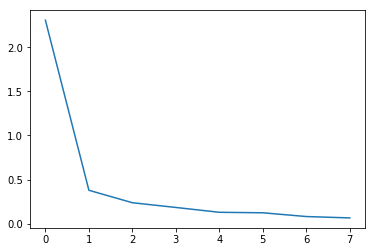

In [10]:
# The number of times we should iterate over the training data. 1 epoch = 1 pass over the training data
epoch = 8

# Train Model with train data

loss_history = []

for i in range(epoch):
    print('####### Epoch ', i)
    for j,[image,label] in enumerate(train_loader):
        # You can try with and without using GPUs, by setting this variable before the loop
        if use_gpu:
            image = image.cuda()
            label = label.cuda()
            
        image = Variable(image)
        label = Variable(label)
        
        
        optimizer.zero_grad() # zero out the gradients from the preivous step 
        predictions = lenet.forward(image) # Do forward pass on the current mini batch
        loss = loss_func(predictions, label) # Compute loss on the current mini batch
        loss.backward() # Do backward pass. That is compute all the gradients for the current minibatch
        optimizer.step() # Update the parameters using the gradients with the learning rate
        
        if j % 100 == 0:
            loss_history.append(loss.data.cpu().numpy()[0])
                    
        # display.clear_output(wait=True)
plt.plot(loss_history)
plt.show()

## Step 5: Compute the Accuracy of the Model on the Test data
Finally we need to check how well the model is doing on the testing data. This step is also done by loading the data one minibatch at a time and computing the accuracy, which is finally averaged.

In [9]:
correct = 0.0
total = 0.0
for mini_batch in test_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    if use_gpu:
        images = images.cuda()
        labels = labels.cuda()
        
    images = Variable(images)
    
    # Doing the Forward pass
    result = lenet(images)
    
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

Accuracy of Test Data: 97.84%
